In [1]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
import datetime as dt
from zigzag_dag26 import zigzag
import talib
from tqdm import tqdm
import colorama as col

In [2]:
%%time
##### Chargement de la base
base = pd.read_csv('Base_Clean/EURUSDH1.csv')

##### On fixe la date en index sous forme de Timestamp
base.set_index(pd.to_datetime(base.Date),drop=True,inplace=True)

###### On drop les colonnes inutiles
base = base.drop(['Date','Total'],axis=1)

##### On enlève les jours correspondant au samedi et au dimanche
base['WE'] = np.where(((base.index.weekday == 5) | (base.index.weekday == 6)),None,base.index.weekday)
base = base.dropna()
base = base.drop(['WE'],axis=1)


CPU times: user 172 ms, sys: 31.4 ms, total: 203 ms
Wall time: 202 ms


In [3]:
base.index[0],base.index[-1]

(Timestamp('2010-11-23 00:00:00'), Timestamp('2020-11-23 23:00:00'))

In [4]:
%%time
_year_bottom = pd.to_datetime('2020-10-23 16:00:00')
_year_top = pd.to_datetime('2020-11-23 16:00:00')

df = base[(base.index>=_year_bottom)&(base.index<=_year_top)]

df_input = df.copy()

df_bt = df.copy()

df.head()

CPU times: user 3.1 ms, sys: 1.23 ms, total: 4.33 ms
Wall time: 3.6 ms


,OpenBid,HighBid,LowBid,CloseBid,OpenAsk,HighAsk,LowAsk,CloseAsk,Open,High,Low,Close
Date,,,,,,,,,,,,
2020-10-23 16:00:00,1.18384,1.18386,1.18247,1.18348,1.18395,1.18398,1.18258,1.18358,1.183895,1.183920,1.182525,1.183530
2020-10-23 17:00:00,1.18348,1.18441,1.18325,1.18423,1.18358,1.18455,1.18338,1.18436,1.183530,1.184480,1.183315,1.184295
2020-10-23 18:00:00,1.18423,1.18437,1.18332,1.18426,1.18436,1.18448,1.18343,1.18440,1.184295,1.184425,1.183375,1.184330
2020-10-23 19:00:00,1.18426,1.18566,1.18416,1.18549,1.18440,1.18579,1.18429,1.18560,1.184330,1.185725,1.184225,1.185545
2020-10-23 20:00:00,1.18549,1.18610,1.18543,1.18580,1.18560,1.18623,1.18554,1.18592,1.185545,1.186165,1.185485,1.185860


In [5]:
_deviation = 0.001
_backstep = 3
_depth = 10
df.shape

(503, 12)

100%|██████████| 503/503 [00:00<00:00, 2264.53it/s]
Il y a  21 signaux VALLEY,  20 signaux PEAK, et  462  signaux sans rien
CPU times: user 289 ms, sys: 11.6 ms, total: 300 ms
Wall time: 274 ms


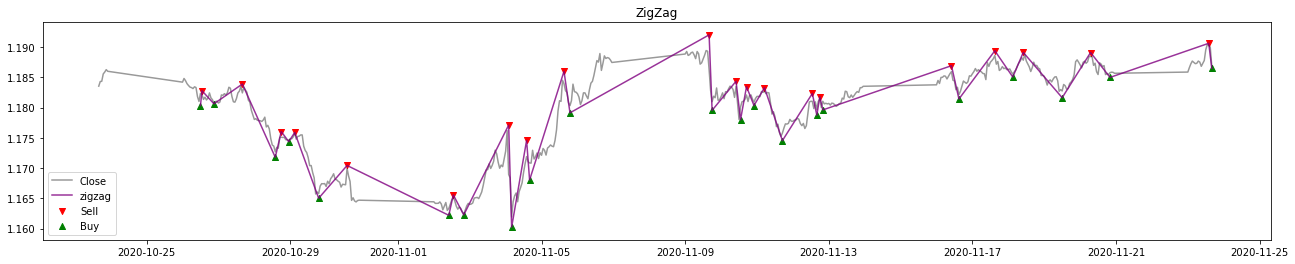

In [6]:
%%time
PEAK,VALLEY = zigzag(df,_deviation, _backstep, _depth)
df['BackHi_pic'] = PEAK
df['BackLo_val'] = VALLEY
#df['BackHi'] = np.where(df.High == df.High.rolling(_backstep).max(),df.High,0)
#df['BackLo'] = np.where(df.Low == df.Low.rolling(_backstep).min(),df.Low,0)

In [7]:
_fibo = 0.618
_err = 0.01

In [8]:
%%time
LASTP = []
LASTV = []
lastv = 0
lastp = 0
for i in tqdm(range(len(df))):
    if df.BackLo_val[i] == 1:
        lastv = df.Low[i]
        LASTV.append(lastv)
        LASTP.append(lastp)
    elif df.BackHi_pic[i] == 1:
        lastp = df.High[i]
        LASTP.append(lastp)
        LASTV.append(lastv)
    else:
        LASTP.append(lastp)
        LASTV.append(lastv)

df['LastP'] = LASTP
df['LastV'] = LASTV

100%|██████████| 503/503 [00:00<00:00, 12372.36it/s]CPU times: user 43.3 ms, sys: 2.51 ms, total: 45.8 ms
Wall time: 44.9 ms



In [9]:
for i in range(26):
    print(i,' --- ',df.LastV[i],' -------------- ' , df.LastV[i-1],' ----- ','oui' if df.LastV[i] == df.LastV[i-1] else 'non')

0  ---  0.0  --------------  1.1864649999999999  -----  non
1  ---  0.0  --------------  0.0  -----  oui
2  ---  0.0  --------------  0.0  -----  oui
3  ---  0.0  --------------  0.0  -----  oui
4  ---  0.0  --------------  0.0  -----  oui
5  ---  0.0  --------------  0.0  -----  oui
6  ---  0.0  --------------  0.0  -----  oui
7  ---  0.0  --------------  0.0  -----  oui
8  ---  0.0  --------------  0.0  -----  oui
9  ---  0.0  --------------  0.0  -----  oui
10  ---  0.0  --------------  0.0  -----  oui
11  ---  0.0  --------------  0.0  -----  oui
12  ---  0.0  --------------  0.0  -----  oui
13  ---  0.0  --------------  0.0  -----  oui
14  ---  0.0  --------------  0.0  -----  oui
15  ---  0.0  --------------  0.0  -----  oui
16  ---  0.0  --------------  0.0  -----  oui
17  ---  0.0  --------------  0.0  -----  oui
18  ---  0.0  --------------  0.0  -----  oui
19  ---  1.1803299999999999  --------------  0.0  -----  non
20  ---  1.1803299999999999  --------------  1.1803299999999

In [14]:
%%time
BUY = [] 
SELL = [] 
INDEXv = []
VALUEv = []
INDEXp = []
VALUEp = []
_pic = 0
_val = 1
_jump = 1
_unlock = 0
_picklock = 0

for i in tqdm(range(0,len(df))):

    if _picklock == 3:
        _unlock = 1
       

    if i == 0:
        BUY.append(0)
        SELL.append(0)
        continue

    if _jump == 1 and _val == 1 and _unlock == 0:
        if df.LastV[i] != df.LastV[i-1]:
            _picklock += 1
        BUY.append(0)
        SELL.append(0)
        continue
        

    if _jump == 1 and _pic == 1 and _unlock == 1:
        if df.LastP[i] == df.LastP[i-1]:
            BUY.append(0)
            SELL.append(0)
            continue
        else:
            _jump = 0

    if _jump == 1 and _val == 1 and _unlock == 1:
        if df.LastV[i] == df.LastV[i-1]:
            BUY.append(0)
            SELL.append(0)
            continue
        else:
            _jump = 0


    if _val == 1 and abs((df.Low[i] - df.LastP[i]) / (df.LastP[i] - df.LastV[i])) >= _fibo * (1+_err) :
        #print('\nDate  :',df.index[i],'i : ',i,'\nLow : ',df.Low[i],'\nLastP : ',df.LastP[i],'\nLastV : ',df.LastV[i],'\nfibo*(1+err : ',_fibo * (1+_err))
        #print('\nho : ',abs(df.Low[i] - df.LastP[i]),'\n ba : ',abs(df.LastP[i] - df.LastV[i]),'\nletou quessé de lunsurlotr: ',abs((df.Low[i] - df.LastP[i]) / (df.LastP[i] - df.LastV[i])),'\n_____________________\n\n')
        VALUEv.append(df.Low[i])
        INDEXv.append(df.index[i])
        BUY.append(1)
        SELL.append(0)
        _val = 0
        _pic = 1
        _jump = 0

    elif _pic == 1 and abs((df.High[i] - df.LastV[i]) / (df.LastV[i] - df.LastP[i])) >= _fibo * (1+_err): 
        print('\nDate  :',df.index[i],'i : ',i,'\nHigh : ',df.High[i],'\nLastV : ',df.LastV[i],'\nLastP : ',df.LastP[i],'\nfibo*(1+err : ',_fibo * (1+_err))
        print('\nho : ',abs(df.High[i] - df.LastV[i]),'\n ba : ',abs(df.LastV[i] - df.LastP[i]),'\nletou quessé de lunsurlotr: ',abs((df.High[i] - df.LastV[i]) / (df.LastV[i] - df.LastP[i])),'\n_____________________\n\n')
        VALUEp.append(df.High[i])
        INDEXp.append(df.index[i])
        BUY.append(0)
        SELL.append(1)
        _val = 1
        _pic = 0
        _jump = 0
        
    else:
        BUY.append(0)
        SELL.append(0)
    
df['BuyRet'] = BUY
df['SellRet'] = SELL

100%|██████████| 503/503 [00:00<00:00, 2664.96it/s]
Date  : 2020-10-29 02:00:00 i :  81 
High :  1.1756449999999998 
LastV :  1.174355 
LastP :  1.176035 
fibo*(1+err :  0.62418

ho :  0.0012899999999997913 
 ba :  0.0016799999999999038 
letou quessé de lunsurlotr:  0.7678571428570626 
_____________________



Date  : 2020-10-29 04:00:00 i :  83 
High :  1.1757950000000001 
LastV :  1.174355 
LastP :  1.175885 
fibo*(1+err :  0.62418

ho :  0.0014400000000001079 
 ba :  0.0015300000000000313 
letou quessé de lunsurlotr:  0.9411764705882865 
_____________________



Date  : 2020-10-29 06:00:00 i :  85 
High :  1.175515 
LastV :  1.174355 
LastP :  1.175885 
fibo*(1+err :  0.62418

ho :  0.0011600000000000499 
 ba :  0.0015300000000000313 
letou quessé de lunsurlotr:  0.7581699346405399 
_____________________



Date  : 2020-10-29 08:00:00 i :  87 
High :  1.17575 
LastV :  1.174355 
LastP :  1.175885 
fibo*(1+err :  0.62418

ho :  0.001395000000000035 
 ba :  0.0015300000000000313 
leto

CPU times: user 70.9 ms, sys: 6.97 ms, total: 77.9 ms
Wall time: 45.4 ms


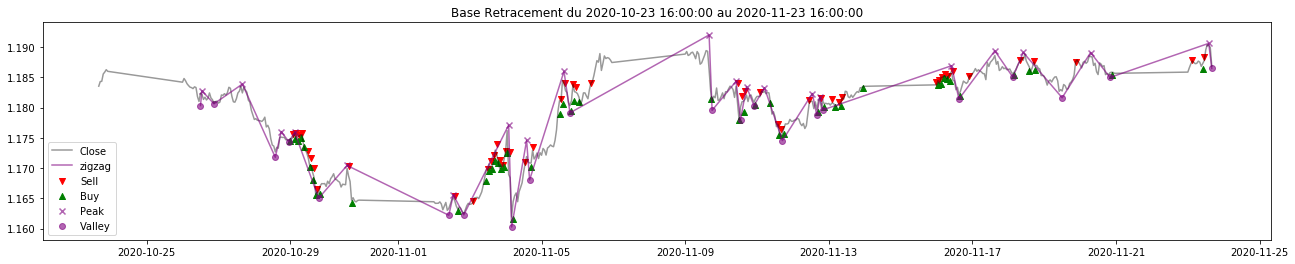

In [15]:
%%time

df_zigzag = pd.DataFrame()
df_zigzag['PeakValley'] = pd.concat([df.BackHi_pic, df.BackLo_val], axis=0, ignore_index=False, sort=True)
df_zigzag['Close'] = pd.concat([df.High, df.Low], axis=0, ignore_index=False, sort=True)
df_zigzag = df_zigzag[df_zigzag.PeakValley==1]
# Sort peak and valley datapoints by date.
df_zigzag = df_zigzag.sort_index()

plt.figure(figsize=(22,4))
plt.title('Base Retracement du '+str(df.index[0])+' au '+str(df.index[-1]))
plt.plot(df.Close,color='black',alpha=0.4,label="Close")
#plt.plot(df.High,color='orange',alpha=0.3,label="High")
#plt.plot(df.Low,color='blue',alpha=0.3,label="Low")
#plt.plot(talib.SMA(df.Close, 200),color='blue',alpha=0.6,label='SMA')


plt.scatter(x=INDEXp,y=VALUEp,color='red',marker='v',label="Sell")
plt.scatter(x=INDEXv,y=VALUEv,color='green',marker='^',label="Buy")

plt.scatter(x=df[df.BackHi_pic==1].index,y=df[df.BackHi_pic==1].High,color='purple',marker='x',label="Peak",alpha=0.6)
plt.scatter(x=df[df.BackLo_val==1].index,y=df[df.BackLo_val==1].Low,color='purple',marker='o',label="Valley",alpha=0.6)
plt.plot(df_zigzag.index.values, df_zigzag['Close'].values,color='purple', label="zigzag",alpha=0.6)
plt.legend()
#plt.savefig('pic.png',dpi=1000)


In [12]:
from vanilla_bt import *
from scipy.ndimage.interpolation import shift

In [15]:
%time
df.Signal = np.where(df.BuyRet == 1,1,np.where(df.SellRet==1,-1,0))
#df.Signal = shift(df.Signal,-1,cval=np.NaN)
bt_tpsl(df,0.009,0.006)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
fermeture long en l'air
Winner Ratio : 27.03 %
Profit Factor :  1.9 % 
 Période du 2019-11-25 00:00:00 au  2020-11-23 16:00:00 
Nombre de trades : 64
Nombre de posistions non fermées 0
Captital initial : 250000
Taille des positions : 50000
Gain :  9404.499999999984 
Capital Final : 259404.49999999997


()

In [14]:
%%time
df.Signal = np.where(df.BuyRet == 1,1,np.where(df.SellRet==1,-1,0))
bt_tpsl_grid(df)
       

Pour un TP de   0.1  et un SL de   0.1 
fermeture short en l'air
Aucun Winner
Profit Factor :  0.0 % 
Nombre de trades : 1
Nombre de posistions non fermées 0
Captital initial : 250000
Taille des positions : 50000
Gain :  -4297.75 
Capital Final : 245702.25

________________________________________________________________________________________

Pour un TP de   0.1  et un SL de   0.09 
fermeture short en l'air
Aucun Winner
Profit Factor :  0.0 % 
Nombre de trades : 1
Nombre de posistions non fermées 0
Captital initial : 250000
Taille des positions : 50000
Gain :  -4297.75 
Capital Final : 245702.25

________________________________________________________________________________________

Pour un TP de   0.1  et un SL de   0.08 
fermeture long en l'air
Winner Ratio : 0.0 %
Profit Factor :  0.05 % 
Nombre de trades : 2
Nombre de posistions non fermées 0
Captital initial : 250000
Taille des positions : 50000
Gain :  -4174.750000000027 
Capital Final : 245825.24999999997

_________________

()